# Imports and Function Definitions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
from polygon import RESTClient

import datetime as dt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [3]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25), n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [713]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [714]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)

In [695]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [696]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [697]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [337]:
fut = pd.read_csv('C:\\Users\\nfischer\\Downloads\\LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('C:\\Users\\nfischer\\Downloads\\GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('C:\\Users\\nfischer\\Downloads\\BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('C:\\Users\\nfischer\\Downloads\\USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [338]:
data_dict = {'fut':fut, 'gas':gas, #'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [309]:
# idx = pd.to_datetime(data_dict['fut']['Local time'])
# idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [340]:
for data in data_dict.keys():
    if data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:     
        ix = pd.to_datetime(data_dict[data]["Local time"].apply(lambda x: " ".join(x.split()[0:2])), format='%d.%m.%Y %H:%M:%S.%f')
        data_dict[data] = data_dict[data].set_index(ix)['Close']

## Merging

In [341]:
# df = pd.DataFrame(index=data_dict['vxx'].index)
df = pd.DataFrame(index=data_dict['fut'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

## Cut to market hours

In [342]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

In [343]:
df = df.loc[ (df['time']>dt.time(7)) & (df['time']<dt.time(16)) ]
df = df[df.index.dayofweek < 5]

The plot below shows the high daily variance and the gaps between data are non-trading hours

In [344]:
df

,Close_fut,Close_gas,Close_btc,Close_bond,date,time
Local time,,,,,,
2020-02-11 07:05:00,50.445,1.7640,9801,162.280,2020-02-11,07:05:00
2020-02-11 07:10:00,50.375,1.7674,9815,162.311,2020-02-11,07:10:00
2020-02-11 07:15:00,50.326,1.7703,9816,162.248,2020-02-11,07:15:00
2020-02-11 07:20:00,50.356,1.7725,9821,162.561,2020-02-11,07:20:00
2020-02-11 07:25:00,50.445,1.7734,9816,162.401,2020-02-11,07:25:00
...,...,...,...,...,...,...
2023-02-10 15:35:00,79.799,2.5718,21531,126.899,2023-02-10,15:35:00
2023-02-10 15:40:00,79.779,2.5721,21487,126.899,2023-02-10,15:40:00
2023-02-10 15:45:00,79.764,2.5739,21552,126.901,2023-02-10,15:45:00


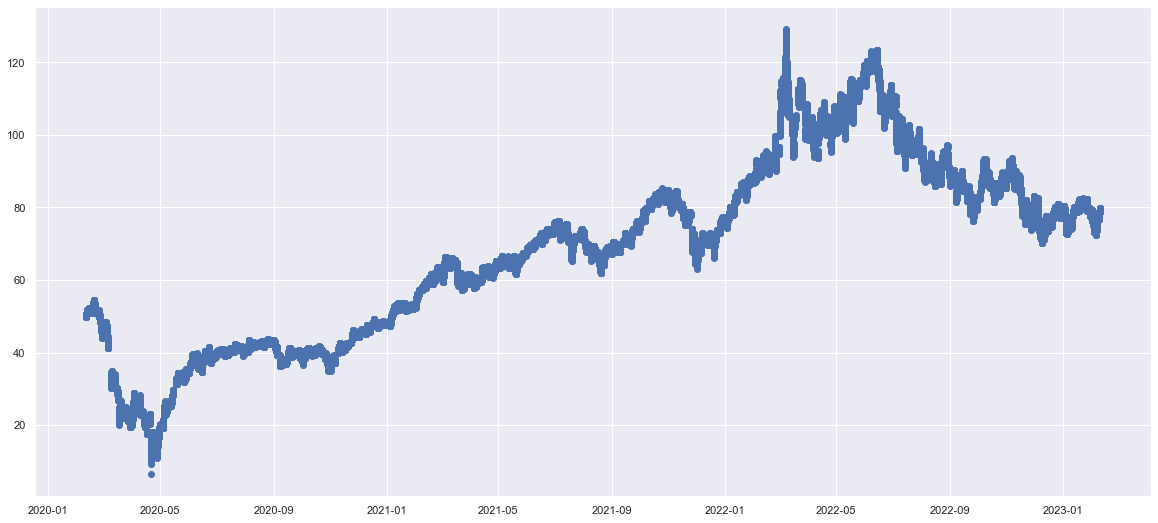

In [345]:
plt.subplots(figsize=(20,9))
plt.scatter(df.index, df['Close_fut'])

# Test Train Splits

## brainstorm:
2 train test splitting techniques: day by day or chunk by chunk.

- day by day: train p of the day test 1-p for each day, record accuracy for each day 
    - bad: small amount of data per train
    - good: consistent times predicted
- chunk by chunk: train n data points test m data points, record accuracy for each chunk
    - bad: inconsistent time predicted; different days have different vol levels and predicting across days could be problematic
    - good: more train data, could get different prediction horizons, no dependency on prediction time

## Day by Day

We split the data into individual days.  We calculate the $n$ period rolling standard deviation as our outcome measure within each day.  Then, we can concat the data together

In [316]:
days = list(set([d.date() for d in df.index]))

In [317]:
set(df.columns) - {'date', 'time'}

{'Close_bond', 'Close_btc', 'Close_fut', 'Close_gas'}

In [357]:
n=12
day_dict = {}
for day in days:
        
    day_dict[day] = df.loc[df['date'] == day]
    del day_dict[day]['date']
    
    for feat in set(df.columns) - {'date', 'time'}:
        day_dict[day][feat] = np.log( day_dict[day][feat] / day_dict[day][feat].shift(1) )
    
    day_dict[day][str(n)+'_oil_std'] = day_dict[day].rolling(n)['Close_fut'].std()
    day_dict[day] = day_dict[day][n:]

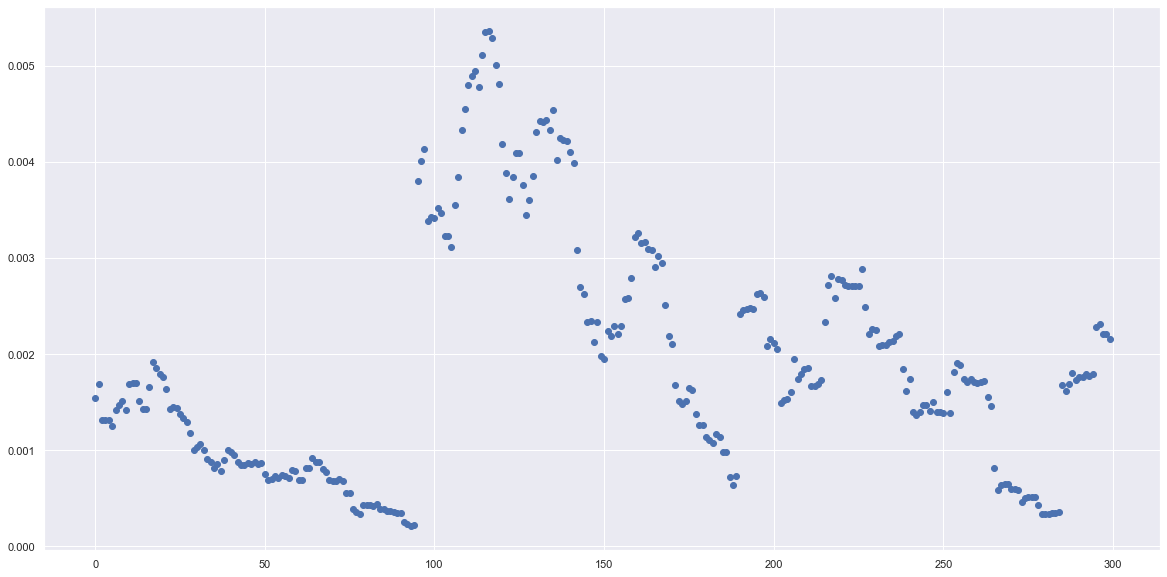

In [358]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

## Examining Temporal Structure

In [320]:
time_dist = concat.groupby('time')[str(n)+'_oil_std'].mean()

<AxesSubplot: xlabel='time'>

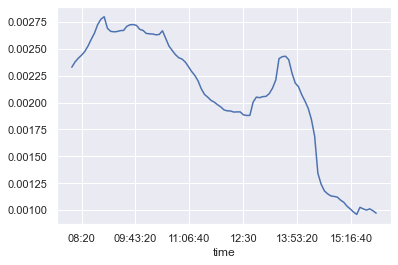

In [321]:
time_dist.plot()

The above plot shows that the trading volatility is clustered around the morning and roughly 2pm (historic oil desk close).  This is to be expected.  It will be important to strip times from the is dataset.

In [322]:
time_rets = concat.groupby('time')['Close_fut'].apply(lambda x: np.mean(abs(x)))

<AxesSubplot: xlabel='time'>

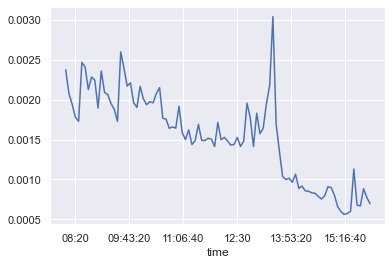

In [323]:
time_rets.plot()

Again we see the largest log returns concentrated around 1:30 pm

## Chunk by Chunk

In [324]:
len(days)

784

In [392]:
chunk_size = 300

In [393]:
chunk_dict = {}

In [394]:
for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    chunk_dict[i] = chunk

In [395]:
chunk_indices = list(chunk_dict.keys())

In [396]:
len(chunk_indices)

280

In [397]:
n=12

for chunk in chunk_indices:    
    for feat in set(df.columns) - {'date', 'time'}:
        chunk_dict[chunk][feat] = np.log( chunk_dict[chunk][feat] / chunk_dict[chunk][feat].shift(1) )
    
    chunk_dict[chunk][str(n)+'_oil_std'] = chunk_dict[chunk].rolling(n)['Close_fut'].std()
    chunk_dict[chunk] = chunk_dict[chunk][n:]

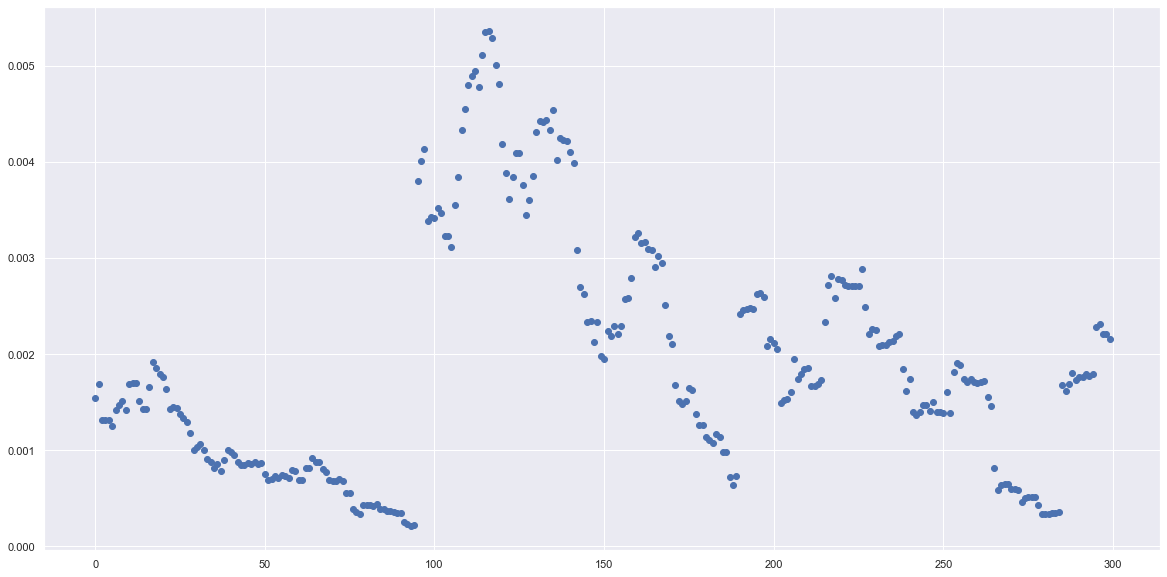

In [369]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

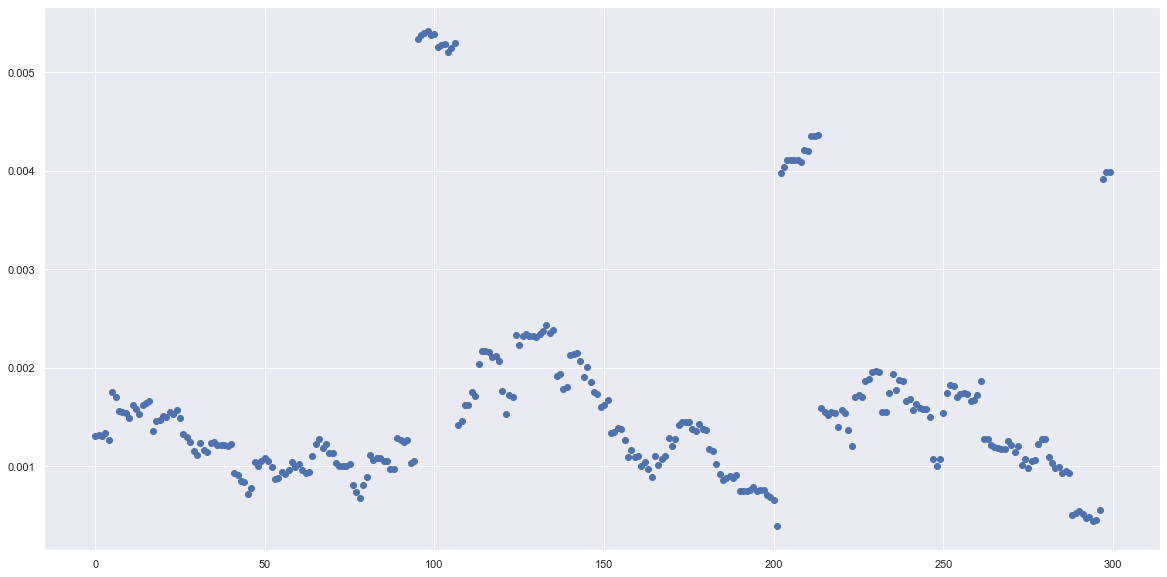

In [398]:
concat = pd.concat(chunk_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

We can see the difference in splitting methods.  New days will appear as large jumps like this rather than smooth as in the day splitting.  

We might be able to fix this with some kind of smoothing technique ie windsorize and replace with some interpolation but it is probably best to just leave it be.  

# Predicting

We will train on a rolling $k$ length period and predict the next bar of vol.

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Initial Model testing

In [251]:
res = {'RF':None, 'GB':None}
for model in res.keys():
    r = model_selection(model)
    res[model] = r

RF
RandomForestRegressor(max_depth=3, n_estimators=10)
MAE:  0.0001873201182509463 
MSE:  3.739762390653617e-08 
RMSE:  0.00019338465271715894
GB
GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10)
MAE:  0.00020812947123731586 
MSE:  4.332753712585249e-08 
RMSE:  0.00020815267744098918


In [244]:
day[77:]

,Close_fut,Close_gas,Close_btc,Close_bond,fut_78_std
Local time,,,,,
2021-09-08 14:25:00+05:00,0.000374,-0.000469,-0.000216,0.000397,0.002224
2021-09-08 14:30:00+05:00,-0.000075,-0.000592,-0.002829,-0.000385,0.002045
2021-09-08 14:35:00+05:00,0.000749,0.000049,-0.000043,0.000000,0.002023
2021-09-08 14:40:00+05:00,-0.001182,-0.003926,-0.000628,0.000000,0.001964
2021-09-08 14:45:00+05:00,0.000135,-0.000223,0.000433,-0.000214,0.001961
2021-09-08 14:50:00+05:00,0.000599,-0.000471,-0.007409,0.000006,0.001950
2021-09-08 14:55:00+05:00,-0.000898,0.000198,0.002772,-0.000568,0.001943
2021-09-08 15:00:00+05:00,0.000225,0.000273,0.003286,-0.000177,0.001827
2021-09-08 15:05:00+05:00,0.000509,-0.000050,0.002386,-0.000208,0.001791


In [252]:
res

{'RF': (RandomForestRegressor(max_depth=3, n_estimators=10),
  array([0.00191586, 0.00188938, 0.00184308, 0.00178188])),
 'GB': (GradientBoostingRegressor(learning_rate=1e-07, n_estimators=10),
  array([0.00187836, 0.00187836, 0.00187836, 0.00187836]))}